In [1]:
import sympy as SY 
import numpy as np 
import matplotlib.pyplot as plt 
#from sympy.abc import *
#from sympy.parsing.sympy_parser import parse_expr
SY.init_printing()

In [2]:
D = SY.diff

# determining the co-ordinates
def get_co_ords(metric:SY.core.add.Add):
    d = SY.Function('d')
    ind = {list(i.atoms())[0]:i 
           for i in list(metric.atoms(d))}
    return list(ind.keys())

# sorting the symbols in order
def sym_qsort(arr:list["symbols"]):
    if len(arr) > 1:
        left , right = [],[]
        for i in arr :
            if i.compare(arr[0]) == 1:
                right.append(i)
            elif i.compare(arr[0]) == -1:
                left.append(i)
        return sym_qsort(left)+[arr[0]]+sym_qsort(right)
    else :
        return arr

# creating the covariant metric tensor
def mtr_tns(mtr:SY.core.add.Add, dims:list["symbols"]):
    d = SY.Function('d')
    m = [[D(mtr, d(i),2)/2 if i==j 
         else D(mtr, d(i),d(j)) 
         for i in dims] for j in dims]
    return m

# calculating the Christoffel symbol components
def christ_i_jk(cov:"SY.Matrix",con :"SY.Matrix",
                X :list['symbols'],
               i : int, j:int, k:int):
    cov = SY.matrix2numpy(cov)
    con = SY.matrix2numpy(con)
    c = [con[i,m]*(D(cov[m,j],X[k]) + D(cov[m,k],X[j])
                     - D(cov[k,j],X[m]))/2 
                    for m in range(len(X))]
    return sum(c)

# calculating  the full Christoffel symbol matrix
def Christoffel(cov: 'SY.Matrix', con:'SY.Matrix',
                co_ord:list['symbols']):
    c = [[[christ_i_jk(cov,con,co_ord,i,j,k)
            for k in range(len(co_ord))]
            for j in range(len(co_ord))]
            for i in range(len(co_ord))]
    return c

# calculating the Riemann curvature tensor components
def R_i_jkl(i:int, j:int, k:int, l:int,
             crist:list['symbols'], X:list['symbols']):
    r = sum([crist[i][k][m]*crist[m][j][l] - 
             crist[i][l][m]*crist[m][k][j] 
             for m in range(len(X))])
    return D(crist[i][j][l], X[k]) - D(crist[i][j][k], X[l]) + r

#  calculating the Riemann curvature tensor
def Riemann_tensor(crist:list[list[list['symbols']]],
                   co_ord:list['symbols']):
    r = [[[[R_i_jkl(i,j,k,l,crist,co_ord)
            for l in range(len(co_ord))]
            for k in range(len(co_ord))]
            for j in range(len(co_ord))]
            for i in range(len(co_ord))]
    return r

# calculating parallel transport of a vector
def par_trans(crist: list[list[list['symbols']]],
              co_ord:list['symbols'],
             A:list['symbols']=None):
    d = SY.Function('d')
    if A is None:
        A = [SY.Symbol(f'A^{i}')
              for i in range(len(co_ord))]
    pts = [sum([crist[i][j][k]*A[j]*d(co_ord[k]) 
           for k in range(len(co_ord))
           for j in range(len(co_ord))])
           for  i in range(len(crist))]
    return pts

# calculating geodesic equations
def geodesics(crist:list[list[list['symbols']]],
             co_ord:list['symbols'],
             s:'SY.Symbol'= SY.Symbol('s')):
    Der = SY.Derivative
    eqs = [SY.Eq( Der(co_ord[i],s,2) + 
                sum([crist[i][j][k]*Der(co_ord[j],s)*Der(co_ord[k],s)
                    for k in range(len(co_ord))
                    for j in range(len(co_ord))]), 0)
                    for i in range(len(co_ord))]
    return eqs


In [3]:
#metric in 3d spherical
#metric = SY.sympify('''d(r)**2 + r**2*d(theta)**2 +
#                      (r*sin(theta))**2*d(phi)**2''')

#metric in 4d cartesian
metric = SY.sympify("r**2*d(theta)**2 +d(r)**2")
metric

In [4]:
var = sym_qsort(get_co_ords(metric)) # final order of co-ordinates
n = len(var) # no. of co-ordinates
n, var

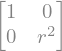

In [5]:
# creating the covariant metric tensor
g_cov = SY.Matrix(mtr_tns(metric, var))
g_cov

In [6]:
# calculating the determinant of covariant metric
g = SY.det(g_cov)
g

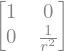

In [7]:
# creating the contravariant metric tensor
g_con = SY.Inverse(g_cov).doit()
g_con

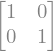

In [8]:
# showing the conjugacy of metric tensors
g_con * g_cov

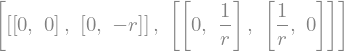

In [9]:
# creating the christoffel symbols
christ = Christoffel(g_cov,g_con,var)
christ

In [10]:
# creating the riemann curvature tensor
Rieman = Riemann_tensor(christ, var)
# printing the curvature tensor
Rieman

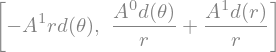

In [11]:
par_trans(christ, var)

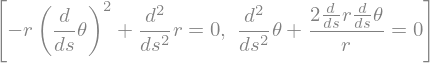

In [12]:
G = geodesics(christ, var)
G

In [ ]:
from sympy.solvers.ode.systems  import dsolve_system
r = SY.Function('r')
theta = SY.Function('theta')
s = SY.Symbol('s')
theta = theta(s)
r = r(s)
dsolve_system(G)

In [1]:
from GTR_script import GTR
gtr = GTR('r**2*d(theta)**2 +d(r)**2')
